# Well-log based reservoir property estimation with machine learning

* __Author__: _Lei Fu, Chicheng Xu, Yanxiang Yu, Michael Ashby, Andy McDonald, and Bin Bai_
* __Date__: November 1st, 2021

- <a>1. Introduction </a>
    - <a>1.1. Background</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Glimpse of Data</a>
- <a>5. Exploratory Data Analysis</a>
- <a>6. Build Machine Models</a>
- <a>7. Prediction</a>
- <a>8. Discussion</a>
- <a>9. Summary</a>

<a></a>

## Abstract

Well-log data play a key role in estimating reservoir properties, including volumes of minerals, porosity, and water saturation that are critical for reserve estimation. A conventional workflow using a multimineral physical model based on core-log integration requires an a priori rock-fluid model; therefore, it is often inadequate in reservoirs of complex minerals such as carbonate or unconventional fields. There is a potential for applying machine learning (ML) for data-driven solutions. In this tutorial, we demonstrated a machine-learning approach to predict reservoir properties based on conventional well logs. This tutorial aims to provide a starting point for the participants of the 2021 Machine Learning Contest organized by the Society of
Petrophysicists and Well Log Analysts (SPWLA) Petrophysical Data-Driven Analytics Special Interest Group (PDDA-SIG). It applied the Random Forest (RF) regression method to simultaneously predict shale volume, porosity, and water saturation based on conventional well logs (gamma ray, bulk density, neutron porosity, resistivity, and sonic). The RF algorithm was tested with a data set from the Equinor Volve Field. A total of 35,046 data points collected from eight wells were used to train and validate the model. The trained model was then applied on the hidden testing data set from four wells in the same field and achieved reasonable accuracy. The solutions from different participants will be ranked based on the averaged root-mean-squared-error (RMSE) score measured on the blind-testing data set.

## <a>1. Introduction</a>

### <a>1.1. Background</a>
Well logs are interpreted and processed to estimate in-situ reservoir properties (including petrophysical, geomechanical, and geochemical properties), which is essential for reservoir modeling, reserve estimation, and production forecasting. The modeling is often based on multimineral physics or empirical formulae. When sufficient training data are available, a machine-learning solution provides an alternative approach to estimate those reservoir properties based on well-log data and usually has less turnaround time and human involvement.

### <a>1.2. Problem Statement</a>
The objective of this contest is to develop data-driven models to estimate reservoir properties, including shale volume, porosity, and fluid saturation, based on a common set of well logs, including gamma ray, bulk density, neutron porosity, resistivity, and sonic. The participants will be provided with log data from eight wells from the same field together with the corresponding reservoir properties estimated by petrophysicists. They need to build a data-driven model using the provided training data set. Following that, they will deploy the newly developed data-driven models on the test data set to predict the reservoir properties based on
the well-log data.

You will be provided with log data from about 10 wells from the same field together with the corresponding reservoir properties estimated by petrophysicists. You need to build a data-driven model using the provided training dataset. Following that, you will deploy the newly developed data-driven models on the test dataset to predict the reservoir properties based on the well log data. 

### <a>1.3. Data Description</a>
#### Files
&gt; #### train.csv
(All the values equals to -9999 are marked as missing values.)
- WELLNUM - Well number
- DEPTH - Depth, unit in feet
- DTC - Compressional Travel-time, unit in nanosecond per foot
- DTS - Shear Travel-time, unit in microseconds per foot
- BS - Bit size, unit in inch
- CAL - Caliper, unit in Inc
- DEN - Density, unit in Gram per cubic centimeter 
- DENC - Corrected density, unit in Gram per cubic centimeter 
- GR - Gamma Ray, unit in API
- NEU - Neutron, unit in dec
- PEF - Photo-electric Factor, unit in barns/e
- RDEP - Deep Resistivity, unit in Ohm.m
- RMED - Medium Resistivity, unit in Ohm.m
- ROP - Rate of penetration, unit in meters per hour
- PHIF - Porosity, a unit equals to the percentage of pore space in a unit volume of rock.
- SW - Water saturation
- VSH - Shale Volume

&gt; #### test.csv
The test data has all features that you used in the train dataset, except PHIF, SW, and VSH.

&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
Submissions are evaluated according to root mean squared error(RMSE)

$$RMSE = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(\hat{\mathbf{y_{i}}} - \mathbf{y_{i}})^{2}} = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(\hat{y}_{1, i} - y_{1, i})^{2}+(\hat{y}_{2, i} - y_{2, i})^{2}+(\hat{y}_{3, i} - y_{3, i})^{2}}$$

where
- $\hat{y_i}$ is the predicted values of the true values $y_i$. Both $\hat{y_i}$ and $y_i$ are vectors with 3 elements: $y_{1,i}$ - PHIF, $y_{2,i}$ - SW, and $y_{3,i}$ - VSH. 
- $m$ is sample size.

**Note**:
- Please remember to use random_state for all randomization steps, so the results are reproducible. 
- PHIF, SW, and VSH are in the same weight during the evaluation. 
- Understanding and optimizing your predictions for this evaluation metric is paramount for this competition.

## <a>2. Imports</a>

In [1]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

# import sklearn libararies
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

## <a>3. Read Data</a>

In [2]:
df1 = pd.read_csv('train.csv')

## <a>4. Glimps Data</a>

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df1.describe()

,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH
count,318967.00,318967.00,318967.00,318967.00,318967.00,318967.00,318967.00,318967.00,318967.00,318967.00,318967.00,318967.00,318967.00,318967.00,318967.00,318967.00,318967.00
mean,4.08,6998.18,-7791.05,-8605.14,-958.27,-6982.04,-7000.76,-7205.37,-43.03,-7007.12,-7221.97,-949.84,-804.02,-989.37,-8515.78,-8515.69,-8585.16
std,2.46,3797.94,4168.06,3491.48,2969.16,4592.48,4582.29,4486.57,990.10,4578.76,4480.14,2944.07,4177.16,3028.43,3554.02,3554.22,3484.04
min,0.00,335.16,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00
25%,2.00,3757.87,-9999.00,-9999.00,8.50,-9999.00,-9999.00,-9999.00,23.33,-9999.00,-9999.00,0.65,0.67,15.20,-9999.00,-9999.00,-9999.00
50%,4.00,6905.18,-9999.00,-9999.00,17.50,-9999.00,-9999.00,-9999.00,55.51,-9999.00,-9999.00,1.10,1.15,24.97,-9999.00,-9999.00,-9999.00
75%,6.00,10052.49,-9999.00,-9999.00,26.00,8.56,2.25,0.03,78.98,0.09,0.06,2.02,2.15,30.63,-9999.00,-9999.00,-9999.00
max,8.00,15651.58,181.81,388.84,36.00,20.33,3.09,0.33,1124.44,1.46,13.84,80266.80,97543.40,208.63,0.40,1.00,3.65


In [4]:
df1.head()

,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH
0,0,335.16,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,5.33,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00
1,0,335.66,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,5.82,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00
2,0,336.16,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,6.52,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00
3,0,336.66,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,7.23,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00
4,0,337.16,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,9.50,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00


## <a>5. Exploratory Data Analysis</a>

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, missing values, outliers, anomalies, patterns, or relationships within the data. 

### Feature Selection
In this tutorial, five commonly used logs (DEN, GR, NEU, PEF, RDEP) are selected together with target columns (PHIF, SW, VSH).

NOTE: 
> Here, we dropped the data point, if any column in (DEN, GR, NEU, PEF, RDEP, PHIF, SW, VSH) contains missing values. As a result, only about $12\%$ of data is left. 

### Handling the Missing Data
"-9999" is shown as the missing value in all features. To handle the missing values, we first replace all the values equal to "-9999" to `np.nan` and then remove all the rows that contain the `nan` by using `dropna()` function. This is another quick implementation provided in the Pandas library.

In [5]:
# For this tutorial, we only use five measurements (DEN, GR, NEU, PEF, RDEP) as input, 
# you should determine which measurements to include in your model. 
col_names =  ['DEN', 'GR', 'NEU', 'PEF', 'RDEP'] + list(df1.columns.values[-3:])

# Replace -9999 with np.nan
df1.replace(['-9999', -9999], np.nan, inplace=True)

# remove all rows that contains missing value 
df1.dropna(axis=0, subset=col_names, inplace=True)
df1.describe()

,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH
count,40192.00,40192.00,17431.00,7198.00,40192.00,40192.00,40192.00,40192.00,40192.00,40192.00,40192.00,40192.00,40192.00,40095.00,40192.00,40192.00,40192.00
mean,5.21,12131.01,76.39,131.02,8.50,8.62,2.41,0.05,39.13,0.18,5.18,26.18,786.81,23.43,0.14,0.66,0.27
std,2.05,1557.91,12.32,14.55,0.00,0.09,0.16,0.02,24.11,0.07,1.72,450.55,6788.72,7.76,0.08,0.36,0.20
min,1.00,8494.00,48.93,74.82,8.50,8.30,1.63,-0.49,4.59,-0.00,-0.01,0.13,0.14,0.34,0.00,0.01,0.00
25%,4.00,11154.20,68.28,123.15,8.50,8.56,2.26,0.03,19.38,0.14,4.58,1.58,1.65,18.82,0.07,0.29,0.11
50%,6.00,11837.27,74.65,131.90,8.50,8.62,2.42,0.05,34.89,0.18,5.41,3.01,3.54,24.98,0.14,0.78,0.23
75%,6.00,13115.81,83.37,138.54,8.50,8.67,2.55,0.06,51.05,0.22,6.10,9.46,11.56,29.91,0.22,1.00,0.35
max,8.00,15566.93,123.25,193.84,8.50,9.18,3.09,0.26,129.34,0.58,13.36,80266.80,62290.80,46.90,0.40,1.00,1.00


### Removing the Outliers
You may find that the maximum values of all features are dramatically larger than their mean values, which indicates anomalies and outliers exist in the data set. It's helpful to remove those abnormal data points to improve the performance of the model trained. Here, we used the Isolation Forest algorithm to remove the outliers. We suggest that the contestants try their best to quality control the log data. More information on this can be found in Misra et al. (2019).

In [6]:
# Remove anomlay
clf = IsolationForest(random_state=0).fit_predict(df1[col_names])
df1 = df1[clf==1]
df1.describe()

,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH
count,35046.00,35046.00,14682.00,6088.00,35046.00,35046.00,35046.00,35046.00,35046.00,35046.00,35046.00,35046.00,35046.00,34949.00,35046.00,35046.00,35046.00
mean,5.21,12193.71,75.43,131.80,8.50,8.62,2.40,0.05,37.39,0.18,5.21,11.93,533.37,23.47,0.15,0.65,0.26
std,2.01,1510.23,10.97,12.85,0.00,0.08,0.15,0.02,21.36,0.05,1.46,22.53,5571.83,7.41,0.08,0.36,0.18
min,1.00,8508.00,49.44,80.00,8.50,8.30,2.11,-0.06,5.00,0.02,0.01,0.27,0.23,0.34,0.00,0.04,0.00
25%,4.00,11179.79,68.06,124.59,8.50,8.56,2.26,0.04,19.37,0.14,4.65,1.59,1.68,19.02,0.07,0.28,0.11
50%,6.00,11834.65,74.26,132.45,8.50,8.62,2.41,0.05,34.41,0.17,5.41,3.16,3.60,24.99,0.15,0.76,0.22
75%,6.00,13142.64,82.37,138.87,8.50,8.67,2.53,0.06,49.15,0.21,6.03,9.09,10.88,29.91,0.22,1.00,0.34
max,8.00,15566.93,123.25,193.84,8.50,9.18,2.77,0.26,117.22,0.38,13.36,259.29,62290.80,46.90,0.31,1.00,0.92


### Correlation

The below function is used to quickly check if there's any correlation between features and targets. It is suggested to conduct this practice for all the features and gain more insights.

Text(0, 0.5, 'VSH')

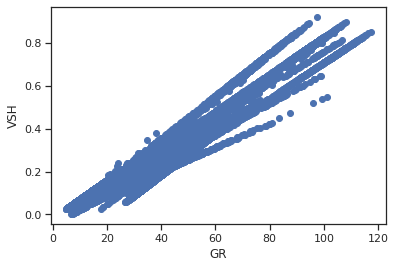

In [7]:
# check if there's any co-linearity between features
# you may check this for all of the features and see if there's any good finding. 
plt.scatter(df1['GR'], df1['VSH'])
plt.xlabel('GR')
plt.ylabel('VSH')

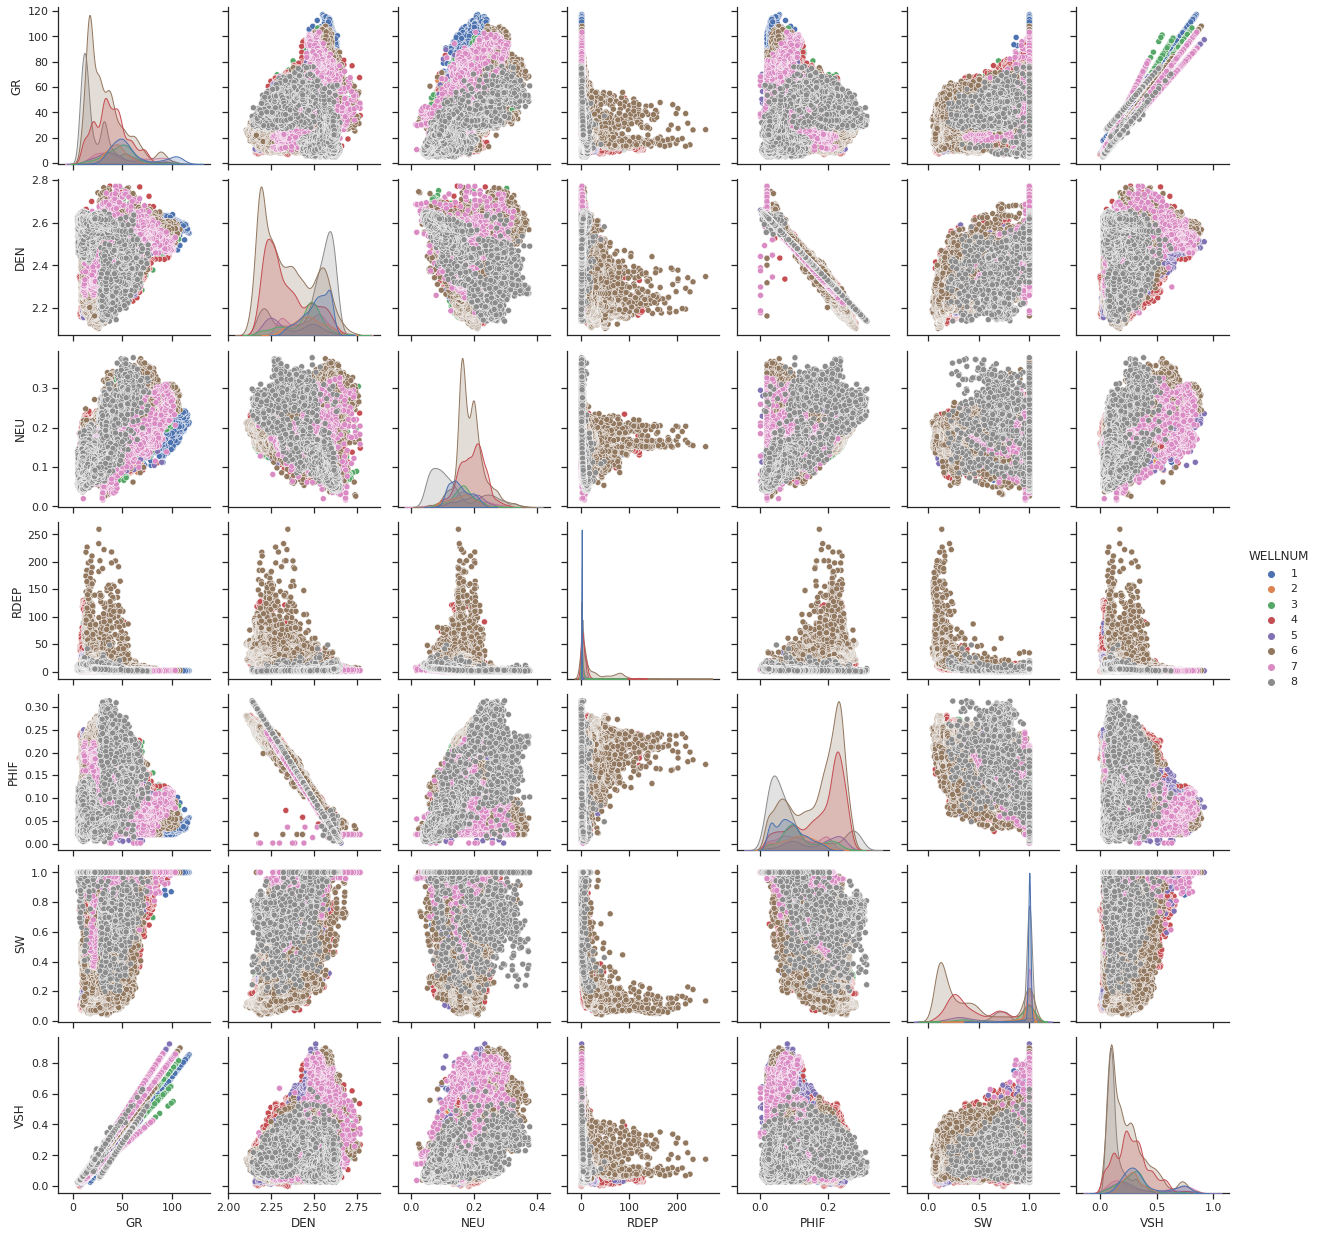

In [8]:
# another library from Seaborn to check the co-linearity
df_new = df1.copy()
df_new['WELLNUM'] = df1['WELLNUM'].astype('str')
sns.pairplot(df_new[['WELLNUM', 'GR', 'DEN', 'NEU', 'RDEP', 'PHIF', 'SW', 'VSH']], hue='WELLNUM')

## <a>6. Build Machine Learning Models</a>

### Identifying the Features and Targets
We will use the first five data columns as the input features for the desired machine-learning task and the last three columns as the targets. We extract the feature vectors and the associated target vectors from the training and testing data set as:

In [9]:
# seperate the features and targets
df1_data = np.array(df1[col_names])
X = df1_data[:,:-3]
Y = df1_data[:,-3:]


# standize the matrix for training data
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Splitting the Data Set Into Training and Testing Data Sets

A standard practice before doing any further data preprocessing and training the supervised learning model is to separate the data into the training and testing data sets, where the testing set can be used to evaluate the generalization of the model in terms of overfitting or underfitting. Once the train-test split is performed, the test data set should not be touched to avoid information leakage from the testing data set to the training data set. The testing data set should be used only for purposes of evaluating the generalization capability of the model. In the code shown below, we used the first seven wells for training and the last well for validation purposes. The participants may apply different strategies to separate the training data set and testing set.

In [10]:
# Here, we separate train and test data by wells
ns = 29171
X_train, X_val = X[:ns], X[ns:]
y_train, y_val = Y[:ns], Y[ns:]

# # if you want to separate train and test data randomly
# # please remember to use random_state for all randomization steps, this will ensure we get the same results 
# # as yours during the validation phase. 
# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=100)

In [11]:
def grid_search(clf, param_grid, X_train=X_train, y_train=y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [12]:
def result_plot(y_predict, y_real, n_points=1000):
    names = ['PHIF', 'SW', 'VSH']
    RMSE, R2 = [], []
    
    for i,name in enumerate(names):
        RMSE.append(np.sqrt(mean_squared_error(y_real[i], y_predict[i])))
        R2.append(r2_score(y_real[i], y_predict[i]))
    
    # check the accuracy of predicted data and plot the result
    print('RMSE:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    for i,name in enumerate(names):
        print(f'    {name:5s} : {RMSE[i]:.5f}')
#     print("-"*65)
    
    print( 'R^2: ', r2_score(y_real, y_predict))
    for i,name in enumerate(names):
        print(f'    {name:5s} : {R2[i]:.5f}')
    
    plt.subplots(nrows=3, ncols=2, figsize=(16,16))

    for i,name in enumerate(names):       
        plt.subplot(3, 2, i*2+1)
        plt.plot(y_real[:n_points, i])
        plt.plot(y_predict[:n_points, i])
        plt.legend(['True', 'Predicted'])
        plt.xlabel('Sample')
        plt.ylabel(name)
        plt.title(name+' Prediction Comparison')

        plt.subplot(3, 2, i*2+2)
        plt.scatter(y_real[:, i], y_predict[:, i], alpha=0.01)
        plt.xlabel('Real Value')
        plt.ylabel('Predicted Value')
        plt.title(name+' Prediction Comparison')
    
    plt.show()

### Training
After training on the X_train and y_train, the Random Forest regression model was then evaluated on the training data set. 

0.9426971081271394
RMSE: 0.00885
    PHIF  : 0.00488
    SW    : 0.00886
    VSH   : 0.00705
R^2:  0.9987278895824251
    PHIF  : 0.99985
    SW    : 0.99951
    VSH   : 0.99969


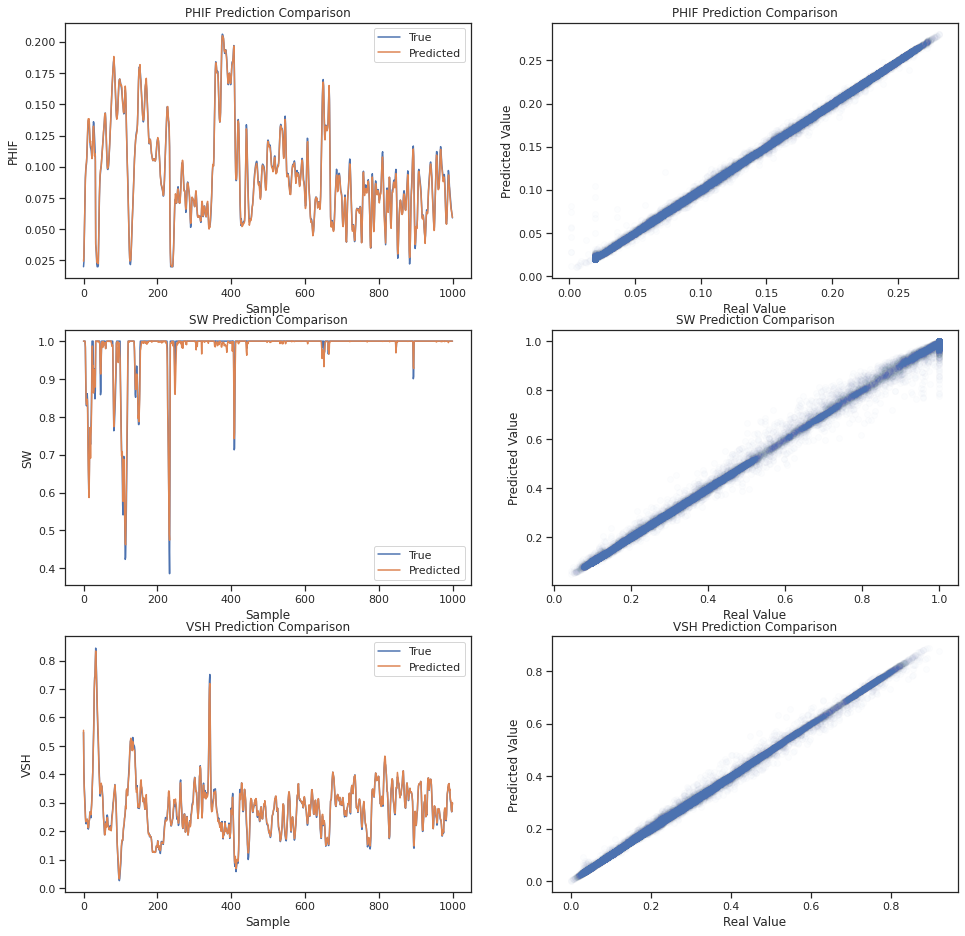

In [13]:
# Random forest model
RF = RandomForestRegressor(n_estimators=100, random_state=100)
RF_best = grid_search(RF, {})
result_plot(RF_best.predict(X_train), y_train)

### Validation
The Random Forest regressor is then applied to the validation data set.

RMSE: 0.09889
    PHIF  : 0.02672
    SW    : 0.06569
    VSH   : 0.09828
R^2:  0.4248374058509217
    PHIF  : 0.99473
    SW    : 0.96315
    VSH   : 0.92142


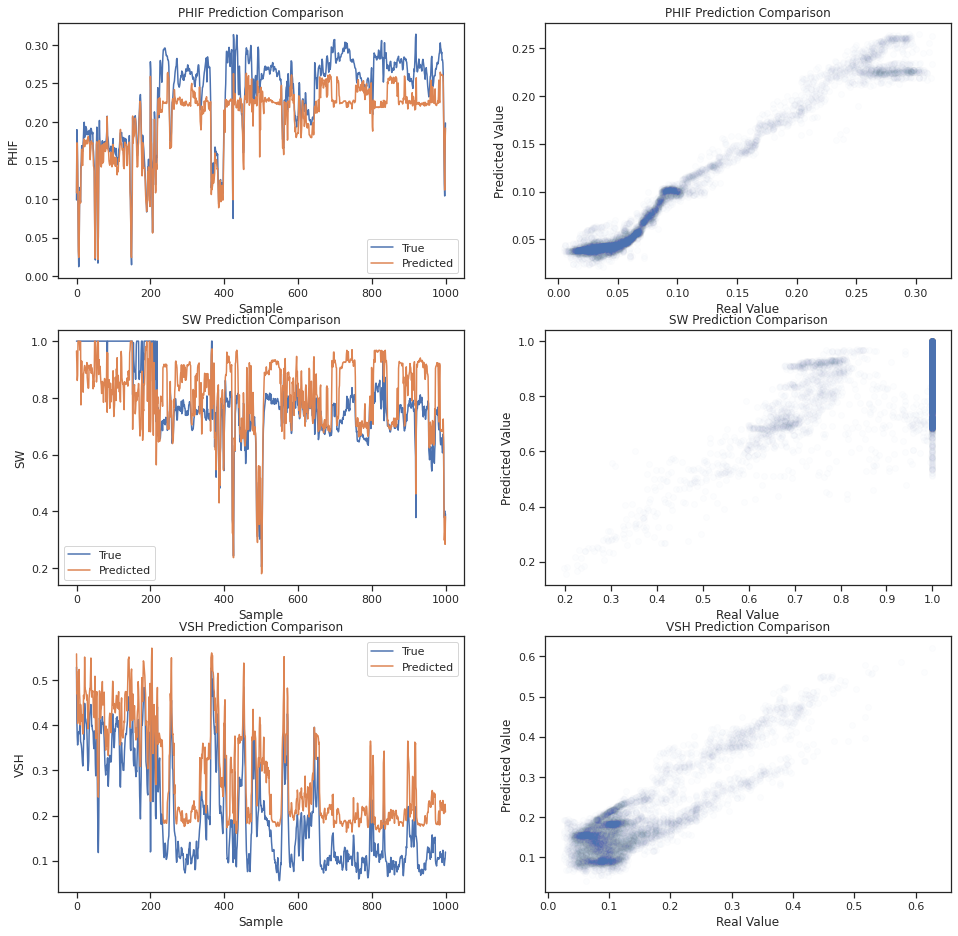

In [14]:
# check the result on validation dataset only
result_plot(RF_best.predict(X_val), y_val)

## <a>7. Prediction</a>

In [15]:
# load test data
df2 = pd.read_csv('test.csv')

# Replace missing value -9999 with np.nan
df2.replace(['-9999', -9999], np.nan, inplace=True)

df2.describe()

,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP
count,11275.00,11275.00,10614.00,3911.00,11275.00,11275.00,11193.00,11193.00,11275.00,11271.00,11193.00,11198.00,11198.00,6394.00
mean,102.01,12643.58,81.92,146.65,8.53,8.53,2.41,0.03,65.90,0.21,4.14,32.27,35.85,44.89
std,1.64,2516.27,11.36,15.44,0.31,0.19,0.15,0.03,56.26,0.08,1.43,265.81,301.75,56.58
min,100.00,10177.50,48.28,98.21,8.50,8.25,1.33,-0.10,3.99,0.04,1.55,0.10,0.10,3.02
25%,100.00,10869.50,74.20,138.00,8.50,8.36,2.27,0.00,30.11,0.16,3.08,1.74,1.70,24.82
50%,101.00,11343.00,82.69,145.53,8.50,8.51,2.45,0.02,53.77,0.20,3.90,2.86,2.76,25.05
75%,104.00,16034.25,88.91,158.38,8.50,8.65,2.54,0.04,94.25,0.24,5.02,8.18,7.88,44.09
max,104.00,17443.50,125.39,190.26,12.25,9.31,3.20,0.19,1711.42,0.73,15.14,5000.00,5000.00,300.11


In [16]:
test_data = np.array(df2.loc[:, col_names[:-3]])

# Imputation transformer for completing missing values.
# You may try better ways to impute the missing values.
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
test_data = imp_mean.fit_transform(test_data)

# standize testing data
X_test = scaler.transform(test_data)

In [17]:
# run the prediction
test_predict = RF_best.predict(X_test)

Generate the csv file, please replace `team_name` and `num_submit` with your own team name and the number of submission. Your submitted csv file should contains 11276 rows: 1st row is column names ['PHIF', 'SW', 'VSH']; 2-11276 rows are your predictions. 

Each team can have 3 submissions. The best score among the 3 submissions will be ranked.

Email your submission to pdda_sig@spwla.org
- Email title: Submission {team_name} {num_submit}
- Attach csv file {team_name}_{n_sub}.csv

In [18]:
# Replace team_name and num_submit
team_name = 'example'
num_submit = 1

# Please don't change codes below
N_SAMPLES = 11275
n_sub_dict = {1:1, 2:2, 3:3}

# Check submission number is correct
try:
    n_sub = n_sub_dict[num_submit]
except KeyError:
    print(f"ERROR!!! Sumbmission Number must be in 1, 2 or 3")

# Check number of samples are correct
if test_predict.shape[0] != N_SAMPLES:
    raise ValueError(f"Number of samples {test_predict.shape[0]} doesn't matches with the correct value {N_SAMPLES}")

# Write results to csv file
output_result = pd.DataFrame({col_names[-3]:test_predict[:,0], col_names[-2]:test_predict[:,1], col_names[-1]:test_predict[:,2]})
output_result.to_csv(path_or_buf=f'./{team_name}_{n_sub}.csv', index=False)

## <a>8. Discussion</a>

There are many things worth further exploration. We list several of them here:
1. Select the most relevant features.
2. Handle the missing values in better ways.
3. Determine anomalous data points in better approaches.
4. Zonate the logs and train different models for different zones.
5. K-fold cross validate the model.
6. Apply more sophisticated models.

## <a>9. Summary</a>

In this tutorial, we demonstrate the machine-learning workflow on a practical petrophysical problem: preparing a data set, training and testing a regression model, and finally, testing the model on the unseen data. Libraries and open-source tools, such as scikit-learn provide powerful algorithms that can be applied to problems with a few lines of code, which greatly helps to facilitate the research of data science in the petrophysics area. In addition to the procedures mentioned above, many other methods may be applied to improve the performance and stability of the model, such as applying better treatments to the missing values and anomalies, train different models for zones with different lithologies, training other regression models, and/
or combining them.

## References
Misra, S., Osogba, O., and Powers, M., 2019, Unsupervised Outlier Detection Techniques for Well Logs and Geophysical Data, Chapter 1, in Machine Learning for Subsurface Characterization, Elsevier, 1–37. ISBN: 978-0-12-817736-5.  
Yu, Y., Xu, C., Misra, S., Li, W., Ashby, M., Pan, W., Deng, T., Jo, H., Santos, J.E., Fu, L. and Wang, C., 2021, Synthetic Sonic Log Generation With Machine Learning: A Contest Summary From Five Methods, Petrophysics, 62(4), 393–406.